# First let's extract the time scale data and the time-course data from the .mat file:

In [1]:
import numpy as np
from loader import load

In [2]:
directory = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

data, n_IC, n_subj, n_trials = load(directory, file)

loading the raw timecourses...
The independent component IC1 of the subject 20 is not in the .mat file.
The independent component IC1 of the subject 21 is not in the .mat file.
The independent component IC2 of the subject 5 is not in the .mat file.
The independent component IC2 of the subject 9 is not in the .mat file.
The independent component IC3 of the subject 1 is not in the .mat file.
The independent component IC3 of the subject 17 is not in the .mat file.
The independent component IC3 of the subject 23 is not in the .mat file.
The independent component IC4 of the subject 12 is not in the .mat file.
Computing and loading the time-frequency wavelet transformation of the 1st trial for all subjects, all IC...
Computing and loading the time-frequency wavelet transformation of the 2nd subject for all IC, all trials...
Loaded


# Now we'll implement the HMM method.

In [3]:
import matplotlib.pyplot as plt
from plotter import *
from wavelet_transform import wavelet_transform

In [4]:
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal

In [5]:
# La fonction embedx copie le vecteur `x` len(lags) fois dans `xe`
# avec des décalages entre lags[0] et lags[-1] (on implémente le délai temporel pour le HMM)

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


# La fonction hmm_tde trouve les paramètres du HMM

def hmm_tde(data: np.array, lags, n_states=3, n_iter=100, n_components=8, 
            covariance_type='full', model_type='GMMHMM', tol=0.01, n_mix=1, **kwargs):
    
    # Embed time serie
    xe, valid = embedx(data, lags)

    pca = PCA(n_components=n_components)
    y = pca.fit_transform(xe[0, :, :])
    
    if model_type=='GMMHMM':
        model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, n_mix=n_mix, **kwargs)
        
    elif model_type=='GaussianHMM':
        model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, **kwargs)
        
    elif model_type=='MultinomialHMM':
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, tol=tol, **kwargs)
    
    else: 
        return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
    model.fit(y)
    gamma = model.predict_proba(y)
    
    return gamma, model, xe

In [6]:
def show_states(subj, IC, trial, lags, n_states, covariance_type, model_type, tol, n_mix, save=False):

    fig = plt.figure(figsize=(6, 6))
    plt.title('State Power Spectrum')
    max_power = np.zeros(n_states)
    max_freq = np.zeros(n_states)
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]> .6, :].T:
            freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        
        max_freq[i] = freqs[np.argmax(psd)]
        max_power[i] = np.amax(psd)

        plt.plot(freqs, psd)
    #     plt.fill_between(x=freqs, y1=psd, alpha=0.3)

    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
    plt.tight_layout()   

    if save==True:
        plt.savefig(f'tde-hmm/states-info_subj{subj}IC{IC}trial{trial}_{n_states}states_'
                    +covariance_type+'_'+model_type+f'_tol{tol}nmix{n_mix}.png', dpi=600)
    
#     plt.close(fig)
    
    return max_freq, max_power
    

In [7]:
# The data we want to analyse with the HMM method
subj=2
IC=1
trial=1
x = data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][trial-1, :].reshape(-1, 1)

In [8]:
# The parameters we change to hope for some results
lags = np.arange(-29, 29)
n_iter=1000
n_states=3    # for the Hidden Markov Model
n_components=8     # For the principal component analysis
covariance_type='diag'
model_type='GMMHMM'
tol=0.001
n_mix=1
save=False

# covars_prior=None
# covars_weight=None
# means_prior=0.0
# means_weight=0.0

In [9]:
# Finding the model
gamma, model, xe = hmm_tde(x, lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                           covariance_type=covariance_type, model_type=model_type, tol=tol, n_mix=n_mix)

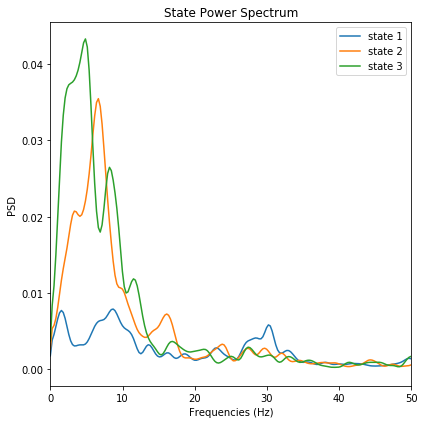

In [10]:
max_freq, max_power = show_states(subj, IC, trial, lags, n_states, covariance_type, model_type, tol, n_mix, save)

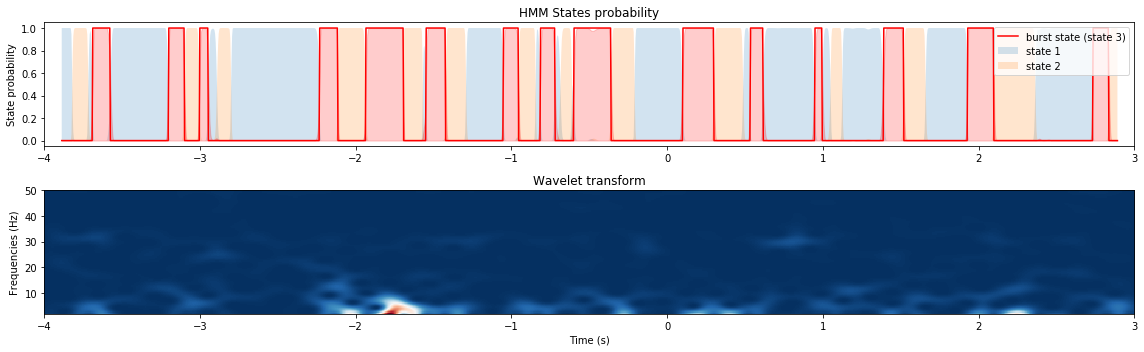

In [11]:
plot_hmm_over_tfr(   
    data, gamma, lags, n_states, max_power, # the data we need for the plot
    
    subj, IC, trial, # which trial is of interest here 
    
    covariance_type, model_type, tol, n_mix, # infos we put in the .png name if we want to save it
    
    save=False # do we really want to save the figure?
)